## Part 1: The Intuition

Before we touch any code, let's make sure the "vibe" of these algorithms makes sense.

### 1. KNN (K-Nearest Neighbors) — "Tell me who your neighbors are."
* **Goal**: Classification or Regression.
* **Logic**: To predict the label of a new point, look at the $K$ closest points in the training set. If the majority of neighbors are "Red," the new point is "Red."
* **Key Concept**: It doesn't "learn" a model in the traditional sense; it just remembers the data and looks at the local neighborhood at inference time.


### 2. K-Means — "Birds of a feather flock together."
* **Goal**: Clustering (Grouping).
* **Logic**: You want to divide $N$ points into $K$ groups. You pick $K$ "centers" (centroids) and tell every point to join the group of the nearest center. Then, you move the centers to the middle of their new groups and repeat.
* **Key Concept**: It's iterative. It keeps refining the groups until the centers stop moving.

## Part 2: NumPy Implementation of K-Means

We will implement **Lloyd’s Algorithm**, which follows a four-step iterative process:

1.  **Initialization**: Pick $K$ random points as initial centroids.
2.  **Assignment**: Assign each data point to the nearest centroid.
3.  **Update**: Calculate the mean of all points assigned to each centroid and move the centroid there.
4.  **Repeat**: Do steps 2 and 3 until convergence (centroids stop changing).

### Step 1: The Setup & Initialization
We will define a `KMeans` class. Your first task is to implement the `init_centroids` method.

**Requirements:**
* Use `np.random.choice` or `np.random.permutation`.
* Ensure you pick $K$ **unique** points from the dataset $X$.

In [ ]:
import numpy as np

class KMeans:
    def __init__(self, k=3, max_iters=100):
        self.k = k
        self.max_iters = max_iters
        self.centroids = None
        self.labels = None
    
    def init_centroids(self, X):
        np.random.seed(42)  # For reproducibility
        random_indices = np.random.choice(X.shape[0], self.k, replace=False)
        self.centroids = X[random_indices]

### Step 2: Assignment (The "Nearest Neighbor" Logic)

Now that we have our initial centroids, every data point needs to look at those centers and ask: **"Which one is closest to me?"**

We use **Euclidean Distance** to determine the proximity. For a point $x$ and a centroid $c$:
$$d(x, c) = \sqrt{\sum_{i=1}^{n} (x_i - c_i)^2}$$

#### Your Task:
Implement the `get_labels` method.
* **Input**: The dataset $X$ (shape: `[n_samples, n_features]`).
* **Logic**: For each row in $X$, calculate the distance to all $K$ centroids and return the index ($0$ to $K-1$) of the closest one.
* **Pro Tip**: Use `np.linalg.norm(X - centroid, axis=1)` to calculate distances efficiently without nested loops.

#### Option A: The Simple Loop (Easier to read)

In [2]:
def get_labels(self, X):
    """
    Returns an array of shape (n_samples,) containing the index 
    of the nearest centroid for each point in X.
    """
    distances = []
    for centroid in self.centroids:
        # Distance from EVERY point in X to this ONE centroid
        distance = np.linalg.norm(X - centroid, axis=1)
        distances.append(distance)
    # distances is now (k, n_samples), so we transpose or axis=0
    return distances.argmin(axis=0)

#### Option B: The "Pro" Way (Broadcasting)

In [ ]:
def get_labels(self, X):
    """
    Returns an array of shape (n_samples,) containing the index 
    of the nearest centroid for each point in X.
    """
    # Add axis to X: (n_samples, n_features) → (n_samples, 1, n_features) (for broadcasting)
    # Subtract centroids (k, n_features) → broadcast to (n_samples, k, n_features) differences
    # Calculate L2 norm along feature axis (axis=2) → distances (n_samples, k)
    distances = np.linalg.norm(X[:, np.newaxis, :] - self.centroids, axis=2)
    
    # Find nearest centroid (min distance) for each sample (axis=1) → labels (n_samples,)
    return distances.argmin(axis=1)

### Step 3: Update (Moving the Centers)

Once every point has a label (a group), we move the centroid to the **geographic center (the mean)** of all points assigned to that group.

#### Your Task:
Implement `get_centroids`.
* **Input**: $X$ and the `labels` generated in Step 2.
* **Logic**: 
    1. Loop through each cluster index $i$ from $0$ to $K-1$.
    2. Filter $X$ to find only the points belonging to cluster $i$.
    3. Calculate the mean of those points along `axis=0`.
    4. Update the centroid position.

In [ ]:
def get_centroids(self, X, labels):
    """
    Update centroids to mean of points in each cluster.
    """
    # New centroids array: (k, num_features) initialized to 0
    new_centroids = np.zeros((self.k, X.shape[1]))
    
    for i in range(self.k):
        points_in_cluster = X[labels == i]  # All points in cluster i
        if len(points_in_cluster) > 0:
            # New centroid = average of cluster points (per feature)
            new_centroids[i] = points_in_cluster.mean(axis=0)
        else:
            new_centroids[i] = self.centroids[i]  # Keep old centroid if cluster empty
    
    return new_centroids

### Step 4: The Final Fit Loop

The `fit` method is the orchestration layer. It brings the **Initialization**, **Assignment**, and **Update** steps together into a loop.

The algorithm stops (converges) when one of two conditions is met:
1.  **max_iters** is reached: To prevent infinite loops.
2.  **Convergence**: The centroids no longer move between iterations. This means the clusters are stable.

#### Convergence Check
We compare `old_centroids` and `new_centroids`. If the difference is zero (or below a very small threshold $\epsilon$), we break the loop.

In [7]:
import numpy as np

class KMeans:
    def __init__(self, k=3, max_iters=100):
        self.k = k
        self.max_iters = max_iters
        self.centroids = None
        self.labels = None
    
    def init_centroids(self, X):
        np.random.seed(42)  # For reproducibility
        random_indices = np.random.choice(X.shape[0], self.k, replace=False)
        self.centroids = X[random_indices]
    
    def get_labels(self, X):
        """
        Returns an array of shape (n_samples,) containing the index 
        of the nearest centroid for each point in X.
        """
        distances = []
        for centroid in self.centroids:
            # Distance from EVERY point in X to this ONE centroid
            distance = np.linalg.norm(X - centroid, axis=1)
            distances.append(distance)
        # distances is now (k, n_samples), so we transpose or axis=0
        return np.argmin(distances, axis=0)
    
    def get_centroids(self, X, labels):
        """
        Update centroids to mean of points in each cluster.
        """
        # New centroids array: (k, num_features) initialized to 0
        new_centroids = np.zeros((self.k, X.shape[1]))
        
        for i in range(self.k):
            points_in_cluster = X[labels == i]  # All points in cluster i
            if len(points_in_cluster) > 0:
                # New centroid = average of cluster points (per feature)
                new_centroids[i] = points_in_cluster.mean(axis=0)
            else:
                new_centroids[i] = self.centroids[i]  # Keep old centroid if cluster empty
        
        return new_centroids
    
    def fit(self, X):
        """
        The main loop that runs the K-Means algorithm.
        """
        # 1. Initialize
        self.init_centroids(X)
        
        for i in range(self.max_iters):
            # Save the old centroids to check for convergence later
            old_centroids = self.centroids.copy()
            # 2. Assignment Step
            self.labels = self.get_labels(X)
            # 3. Update Step
            self.centroids = self.get_centroids(X, self.labels)
            # 4. Convergence Check
            # If the change is 0, we have found the optimal clusters for this run.
            if np.all(old_centroids == self.centroids):
                print(f"Converged at iteration {i}")
                break
        
        return self.labels

## Visualization

Converged at iteration 5


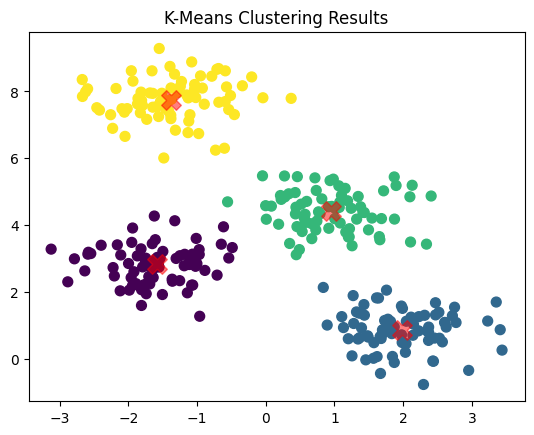

In [8]:
# Create a synthetic dataset
from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

# Run your KMeans
model = KMeans(k=4)
labels = model.fit(X)

import matplotlib.pyplot as plt
# Plot the results
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')
plt.scatter(model.centroids[:, 0], model.centroids[:, 1], c='red', s=200, alpha=0.5, marker='X')
plt.title("K-Means Clustering Results")
plt.show()